# Comparison of stress functions from stress-ng

The purpose of this analysis is to find out which method from stress-ng put a higher load on the CPU.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from codes.clean import clean_energy_data
from codes.transform import remove_delay

import os

The files are located in the `csvfiles/stress/short` folder. It includes all tests that were run with 2 minutes duration.

The tests were run with the following conditions:
- The stress tests were made with the phone in idle mode, meaning it's screen was turned on, but no applications were running (besides the stress test).
- The frequency for both clusters were set to the maximum available on Samsung A8 (1.568 GHz for LITTLE, 2.148 GHz for big)

In [2]:
STRESS_PATH = 'csvfiles/stress/short'
dirty_stress_data = {}

# Reads all CSV data into dataframes
for file in os.listdir(STRESS_PATH):
    (_, sep, rest) = file.partition('-')
    (stress_method, sep, _) = rest.partition('-')
    csv_path = os.path.join(STRESS_PATH, file)
    dirty_stress_data[stress_method] = pd.read_csv(csv_path)

In [14]:
# One example from the tests
dirty_stress_data['ackermann'].head()

timestamp  iteration   little      big  thermalzone_temp0  \
7   1575306125743          0  1568000  2148000                620   
8   1575306126306          0  1568000  2148000                640   
9   1575306126901          0  1568000  2148000                640   
10  1575306127462          0  1568000  2148000                650   
11  1575306128040          0  1568000  2148000                650   

    thermalzone_temp1  thermalzone_temp2  thermalzone_temp3  \
7                 620                460                317   
8                 640                470                317   
9                 640                470                317   
10                650                480                317   
11                650                480                317   

    thermalzone_temp4  current_now  current_avg  voltage_now  voltage_avg  \
7                 293         -908         -290      4206000      4206000   
8                 293         -908         -290      4206000      4206000   
9                 293         -908         -290      4206000      4206000   
10                293         -908         -290      4206000      4206000   
11                293         -908         -290      4206000      4206000   

    batt_temp  capacity health       status  
7         293        97   GOOD  DISCHARGING  
8         293        97   GOOD  DISCHARGING  
9         293        97   GOOD  DISCHARGING  
10        292        97   GOOD  DISCHARGING  
11        292        97   GOOD  DISCHARGING

In [4]:
# Removes the initial data that comes from when the device was still connected via USB
for method, data in dirty_stress_data.items():
    mask = data['status'] != 'CHARGING'
    dirty_stress_data[method] = data[mask]

In [5]:
stress_data = {method: clean_energy_data(data) for method, data in dirty_stress_data.items()}
stress_data['ackermann'].head()

timestamp  iteration   little      big  \
datetime                                                              
2019-12-02 17:02:05.743  1575306125743          0  1568000  2148000   
2019-12-02 17:02:06.306  1575306126306          0  1568000  2148000   
2019-12-02 17:02:06.901  1575306126901          0  1568000  2148000   
2019-12-02 17:02:07.462  1575306127462          0  1568000  2148000   
2019-12-02 17:02:08.040  1575306128040          0  1568000  2148000   

                         thermalzone_temp0  thermalzone_temp1  \
datetime                                                        
2019-12-02 17:02:05.743                620                620   
2019-12-02 17:02:06.306                640                640   
2019-12-02 17:02:06.901                640                640   
2019-12-02 17:02:07.462                650                650   
2019-12-02 17:02:08.040                650                650   

                         thermalzone_temp2  thermalzone_temp3  \
datetime                                                        
2019-12-02 17:02:05.743                460                317   
2019-12-02 17:02:06.306                470                317   
2019-12-02 17:02:06.901                470                317   
2019-12-02 17:02:07.462                480                317   
2019-12-02 17:02:08.040                480                317   

                         thermalzone_temp4  current_now  current_avg  \
datetime                                                               
2019-12-02 17:02:05.743                293       -0.908        -0.29   
2019-12-02 17:02:06.306                293       -0.908        -0.29   
2019-12-02 17:02:06.901                293       -0.908        -0.29   
2019-12-02 17:02:07.462                293       -0.908        -0.29   
2019-12-02 17:02:08.040                293       -0.908        -0.29   

                         voltage_now  voltage_avg  batt_temp  capacity health  \
datetime                                                                        
2019-12-02 17:02:05.743        4.206        4.206       29.3        97   GOOD   
2019-12-02 17:02:06.306        4.206        4.206       29.3        97   GOOD   
2019-12-02 17:02:06.901        4.206        4.206       29.3        97   GOOD   
2019-12-02 17:02:07.462        4.206        4.206       29.2        97   GOOD   
2019-12-02 17:02:08.040        4.206        4.206       29.2        97   GOOD   

                              status     power  
datetime                                        
2019-12-02 17:02:05.743  DISCHARGING  0.003819  
2019-12-02 17:02:06.306  DISCHARGING  0.003819  
2019-12-02 17:02:06.901  DISCHARGING  0.003819  
2019-12-02 17:02:07.462  DISCHARGING  0.003819  
2019-12-02 17:02:08.040  DISCHARGING  0.003819

In [6]:
stress_wd = {method: remove_delay(data) for method, data in stress_data.items()}
stress_wd['ackermann'][['voltage_now', 'voltage_avg']].head()

voltage_now  voltage_avg
timestamp                          
0                4.206        4.206
563              4.206        4.206
1158             4.206        4.206
1719             4.206        4.206
2297             4.206        4.206

In [10]:
columns = [data['power'] for data in stress_wd.values()]
keys = [method for method in stress_wd]

powers = pd.concat(columns, axis=1, keys=keys)

# Uses ffill to remove NaN that are caused due to timestamps not being spread exactly half a second apart
powersf = powers.ffill()

# Transforms timestamps from milliseconds to seconds
powersf.index = powersf.index.map(lambda milli: milli / 1000)

print(f'Duration in seconds: {powersf.index[-1]}')

# Integrate instantaneous power (values) over time (index)
avg_power = powersf.apply(lambda x: np.trapz(x.values, x.index) / x.index[-1])

Duration in seconds: 117.29


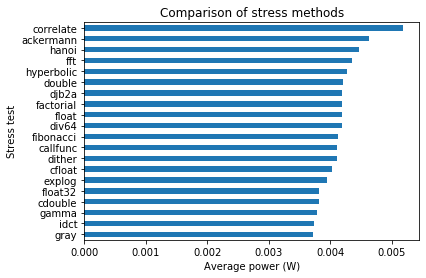

In [13]:
avg_power.sort_values().tail(20).plot(kind='barh')
_ = plt.title('Comparison of stress methods')
plt.ylabel('Stress test')
_ = plt.xlabel('Average power (W)')